In [1]:
%run utils.ipynb

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

In [4]:
df=pd.read_csv("../data/train.csv")

#drop some useless columns
cols_to_drop=["Id","PID"]
df=df.drop(columns=cols_to_drop)

#drop outliers identified in part 1
df=df[df['Gr Liv Area']<=4500]
df=df[df['SalePrice']>np.expm1(10)]

df_copy=df.copy()

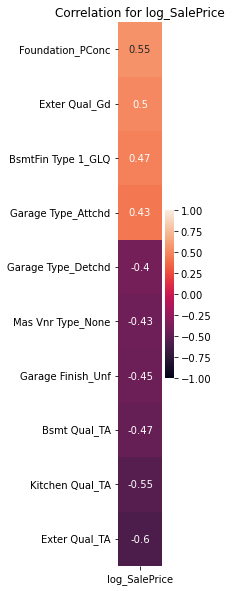

In [5]:
#change SalePrice to log_SalePrice
df=log_and_return(df_copy.copy(),"SalePrice",drop=True)

#one hot encode only categorical features
df_new=onehot_encode_categorical_features(df,return_number=False,label="log_SalePrice")

# display(df_new.dtypes)
#look at correlation to log_saleprice
categorical_features_to_keep=single_correlation_map(df_new,"log_SalePrice",corr_threshold=0.4)

Okay, so we'll add these few features to our list of features from part 3.

In [6]:
features_to_keep=['Bsmt Unf SF', 'Total Bsmt SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Gr Liv Area',
 'Overall Qual', 'Year Built', 'Overall Cond', 'Functional', 'Garage Cars', 'Lot Area', 'Lot Frontage',
 'Year Remod/Add', 'Exter Qual', 'Fireplace Qu', 'Kitchen Qual', *categorical_features_to_keep]

In [7]:
cols_to_impute_with_none=["Pool QC","Misc Feature","Alley","Fence","Fireplace Qu",
                          "Garage Finish","Garage Qual","Garage Cond","Garage Type",
                         "Bsmt Exposure","BsmtFin Type 2","Bsmt Cond","Bsmt Qual","BsmtFin Type 1",
                         "Mas Vnr Type"]

cols_to_impute_with_zero=["Garage Yr Blt","Mas Vnr Area","Bsmt Full Bath","Bsmt Half Bath","Garage Area",
                         "Garage Cars","Total Bsmt SF","Bsmt Unf SF","BsmtFin SF 2","BsmtFin SF 1"]

cols_to_impute_with_mode=["Electrical"]

In [8]:
correlated_to_drop=["1st Flr SF","Garage Yr Blt","TotRms AbvGrd","Garage Area"]

In [9]:
#Create a regressor to dynamically creates a pipeline
def create_regressor(model,**kwargs):
    '''
    model: estimator instance
    return: TransformedTargetRegressor
    '''
    pipeline=Pipeline(steps=[
        ('drop_correlated',DropCorrelated(correlated_to_drop)),
        ('ms_subclass_convert',MSSubClassConvert()),
        ('standard_impute',StandardImpute(none=cols_to_impute_with_none,
                                          zero=cols_to_impute_with_zero,
                                          mode=cols_to_impute_with_mode)),
        ('lot_frotage_impute',LotFrontageImpute()),
        ('ordinal_to_numerical',OrdinalToNumeric()),
        ('onehotencode',OneHotEncode()),
#         ('feature_selector',FeatureSelector(**kwargs)),
        ('align_train_and_predict',AlignTrainPredict(**kwargs)), #This is to align the train and predict DF in case they are different
        ('passthrough',Passthrough()), #Passthrough step, does nothing. Only exists to allow external code to retrieve feature names.
        ('robustscalar',RobustScaler()),
        ('model',model)
    ])
    
    return TransformedTargetRegressor(regressor=pipeline,
                                    func=np.log1p,
                                    inverse_func=np.expm1
                                    )

In [10]:
df=df_copy.copy()

#set up X and Y
X=df.drop(columns="SalePrice")
y=df["SalePrice"]

#make a backup copy
X_copy=X.copy()
y_copy=y.copy()

In [11]:
RMSE=[]
coefficients=[]
feature_names=None

#create regressor and instruct to keep only numerical features
lr=create_regressor(LinearRegression(),feature_names=features_to_keep)

#run 10 K Folds and store the coefficients and RMSE to a list.
kf=KFold(n_splits=5,random_state=30,shuffle=True)
for train_index, test_index in tqdm(kf.split(X_copy.copy())):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lr.fit(X_train,y_train)
    ypred=lr.predict(X_test)
    RMSE.append(mean_squared_error(y_test,ypred,squared=False))
    coefficients.append(lr.regressor_['model'].coef_)
    feature_names=list(lr.regressor_['passthrough'].get_feature_names())

0it [00:00, ?it/s]

In [12]:
np.mean(RMSE)

22657.117510963883

In [13]:
feature_names

['Bsmt Unf SF',
 'Total Bsmt SF',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Gr Liv Area',
 'Overall Qual',
 'Year Built',
 'Overall Cond',
 'Functional',
 'Garage Cars',
 'Lot Area',
 'Lot Frontage',
 'Year Remod/Add',
 'Exter Qual',
 'Fireplace Qu',
 'Kitchen Qual',
 'Foundation_PConc',
 'Exter Qual_Gd',
 'BsmtFin Type 1_GLQ',
 'Garage Type_Attchd',
 'Garage Type_Detchd',
 'Mas Vnr Type_None',
 'Garage Finish_Unf',
 'Bsmt Qual_TA',
 'Kitchen Qual_TA',
 'Exter Qual_TA']

Looks reasonable. Let's look at the coefficients once more.

In [14]:
#sort the coefficients from the regressor
dfcoeff=np.abs(pd.DataFrame(coefficients,columns=feature_names).mean()).sort_values(ascending=False)

In [15]:
dfcoeff

Gr Liv Area           1.551539e-01
Overall Qual          1.285110e-01
Year Built            1.270616e-01
Total Bsmt SF         7.128060e-02
Fireplace Qu          6.935099e-02
BsmtFin SF 1          6.364296e-02
Overall Cond          4.807237e-02
Garage Cars           3.688087e-02
Functional            3.359052e-02
Year Remod/Add        3.286243e-02
Exter Qual            3.220487e-02
Foundation_PConc      3.126500e-02
Garage Type_Attchd    2.982593e-02
Kitchen Qual          2.922271e-02
Garage Type_Detchd    2.530864e-02
Lot Frontage          2.046379e-02
Lot Area              1.792209e-02
Bsmt Unf SF           1.533706e-02
Mas Vnr Type_None     5.473898e-03
BsmtFin SF 2          4.613639e-05
Exter Qual_Gd         1.387779e-18
BsmtFin Type 1_GLQ    5.204170e-19
Garage Finish_Unf     0.000000e+00
Bsmt Qual_TA          0.000000e+00
Kitchen Qual_TA       0.000000e+00
Exter Qual_TA         0.000000e+00
dtype: float64

In [ ]:
results=[]

for coeff_top_x in tqdm(range(3,len(feature_names)+1)):
    # features_to_keep
    features_to_keep=list(dfcoeff.head(coeff_top_x).index)
    
    RMSE=[]

    lr=create_regressor(LinearRegression(),feature_names=features_to_keep)

    kf=KFold(n_splits=10,random_state=30,shuffle=True)
    for train_index, test_index in kf.split(X_copy.copy()):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        lr.fit(X_train,y_train)
        ypred=lr.predict(X_test)
        RMSE.append(mean_squared_error(y_test,ypred,squared=False))

    results.append({'Feature Count':coeff_top_x,'RMSE':np.mean(RMSE)})

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
RMSE_vs_feat_count(pd.DataFrame(results))

Sweet spot seems to be a sweet spot at 17, about 23 RMSE.
Let's pick the top 17 features here.

In [ ]:
features_to_keep=list(dfcoeff.head(17).index)
features_to_keep

### Try a submission

In [ ]:
#Instantiate a copy of Tester helper class
tester=Tester("../data/test.csv")

In [ ]:
lr.fit(X, y)#obtain a copy of the test set
df_test=tester.get_test_df()

In [ ]:
#reset the df
X=X_copy.copy()

#instantiate and train the model using the entire dataset
lr=create_regressor(LinearRegression(),feature_names=features_to_keep)
lr.fit(X,y)

In [ ]:
#make prediction
ypred=lr.predict(df_test)

In [ ]:
tester.write_submission(ypred,"../data/04_categorical_features.csv")